In [1]:
from exp.utils import *
from exp.models import *
from exp.losses import *
from tqdm.notebook import tqdm
from multiprocessing import Pool

import torch
import torch.nn as NN
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [2]:
picked_labels = ["Atelectasis"]#["Atelectasis", "Cardiomegaly", "Pneumonia"]
already_pretrained_labels = []#["Atelectasis"]#["Cardiomegaly", "Pneumonia"]
already_pretrained_lrs = []#[1e-8]#[1e-10, 1e-10]
already_pretrained = {k:v for k,v in zip(already_pretrained_labels, already_pretrained_lrs)}
already_trained = []#["Atelectasis"]
train_labels = [l for l in picked_labels if l not in already_trained]

In [3]:
rhos =[0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

In [4]:
log = {"label":[], "rho":[], "loss":[], "acc":[], "auroc":[]}

for label in sorted(train_labels):
    
    for rho in rhos:
        last_epoch = False
        if rho == rhos[-1]: last_epoch = True

        print(f"Training model to classify '{label}' with rho '{rho}'")

        # Seed
        seed = 92
        seed_everything(seed)

        # Inital setup
        model_name = f"Rho_{int(rho*100)}_{label}"#f"sam_densenet_v1_{label}"
        model_type = "densenet"
        bs = 16
        lr = 1e-3
        epochs = 1
        patience = 1
        with_reset = False
        image_size = (224, 224)
        device = get_device()
        labels = get_labels()

        # Load data
        train_df, valid_df, test_df = get_dataframes(include_labels=labels, 
                                                     small=True, small_fraction=0.33)
        #print(train_df.shape, valid_df.shape, test_df.shape)
        train_df = get_binary_df(label, train_df)
        valid_df = get_binary_df(label, valid_df)
        test_df = get_binary_df(label, test_df)

        # Compute label weights
        train_label = train_df[[label]].values
        neg_weights, pos_weights = compute_class_freqs(train_label)
        neg_weights, pos_weights = torch.Tensor(neg_weights), torch.Tensor(pos_weights)
        #print(neg_weights, pos_weights)

        # Get transforms
        train_tfs, test_tfs = get_transforms(image_size=image_size)

        # Create datasets
        train_ds = CRX8_Data(train_df, get_image_path(), label, image_size=image_size, transforms=train_tfs)
        valid_ds = CRX8_Data(valid_df, get_image_path(), label, image_size=image_size, transforms=test_tfs)
        test_ds  = CRX8_Data(test_df , get_image_path(), label, image_size=image_size, transforms=test_tfs)

        # Create dataloaders
        train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
        valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)
        test_dl  = DataLoader(test_ds,  batch_size=bs, shuffle=False)
        dataloaders = {
            "train": train_dl,
            "val": valid_dl,
            "test": test_dl
        }

        model = pretrained_densenet121()
        model = model.to(device)

        # Get criterion and optimizer
        criterion = get_weighted_loss_with_logits(pos_weights.to(device), 
                                                  neg_weights.to(device))
        sam_optimizer = SAM(model.parameters(), torch.optim.Adam, lr=lr, rho=rho)

        # Train model
        model, history = fit(model, criterion, sam_optimizer, 
                             dataloaders, model_name, epochs, 
                             lr, sam=True, with_reset=with_reset, metric="loss", patience=patience)
        
        log["label"].append(label)
        log["rho"].append(rho)
        log["loss"].append(history[f"e{epochs}_val"]["loss"].mean())
        log["acc"].append(history[f"e{epochs}_val"]["acc"])
        log["auroc"].append(history[f"e{epochs}_val"]["auroc"])
        print()

FERTIG()

Training model to classify 'Atelectasis' with rho '0.005'
Using the GPU!
Epoch 1:



Train: Loss: 0.149, Acc: 0.535, AUROC: 0.561



Val: Loss: 0.155, Acc: 0.385, AUROC: 0.562
Saved model with loss 0.1555

Training model to classify 'Atelectasis' with rho '0.01'
Using the GPU!
Epoch 1:



Train: Loss: 0.150, Acc: 0.524, AUROC: 0.544



Val: Loss: 0.158, Acc: 0.339, AUROC: 0.522
Saved model with loss 0.1582

Training model to classify 'Atelectasis' with rho '0.02'
Using the GPU!
Epoch 1:



Train: Loss: 0.149, Acc: 0.534, AUROC: 0.558



Val: Loss: 0.338, Acc: 0.598, AUROC: 0.540
Saved model with loss 0.3379

Training model to classify 'Atelectasis' with rho '0.05'
Using the GPU!
Epoch 1:



Train: Loss: 0.150, Acc: 0.517, AUROC: 0.534



Val: Loss: 0.155, Acc: 0.637, AUROC: 0.502
Saved model with loss 0.1555

Training model to classify 'Atelectasis' with rho '0.1'
Using the GPU!
Epoch 1:



Train: Loss: 0.151, Acc: 0.526, AUROC: 0.512



Val: Loss: 0.207, Acc: 0.467, AUROC: 0.505
Saved model with loss 0.2068

Training model to classify 'Atelectasis' with rho '0.2'
Using the GPU!
Epoch 1:



Train: Loss: 0.152, Acc: 0.619, AUROC: 0.503



Val: Loss: 0.155, Acc: 0.429, AUROC: 0.533
Saved model with loss 0.1551

Training model to classify 'Atelectasis' with rho '0.5'
Using the GPU!
Epoch 1:



Train: Loss: 0.208, Acc: 0.541, AUROC: 0.504



Val: Loss: 0.301, Acc: 0.793, AUROC: 0.481
Saved model with loss 0.3014

FERTIG! :D


In [7]:
pd.DataFrame(log).sort_values("loss")

,label,rho,loss,acc,auroc
5,Atelectasis,0.200,0.155102,0.428722,0.533208
0,Atelectasis,0.005,0.155457,0.385114,0.562451
3,Atelectasis,0.050,0.155497,0.636953,0.502326
1,Atelectasis,0.010,0.158178,0.338704,0.522149
4,Atelectasis,0.100,0.206850,0.466900,0.505487
6,Atelectasis,0.500,0.301449,0.792644,0.481315
2,Atelectasis,0.020,0.337928,0.597548,0.540030


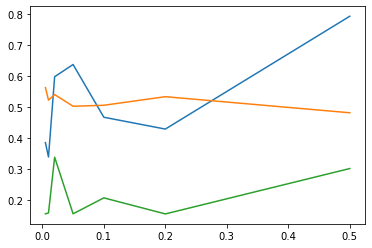

In [6]:
plt.plot(log["rho"], log["acc"])   # blue
plt.plot(log["rho"], log["auroc"]) # orange
plt.plot(log["rho"], log["loss"])  # green